In [26]:
# NOTE: File for comparing the Mueller matrices for Eta Crv, first 8 HWP positions
import os
import sys
py_files_dir = os.path.abspath("../programs/py_files/")
sys.path.insert(0, py_files_dir)

import matplotlib.pyplot as plt
import itertools
import helper_functions as funcs
import instrument_matrices as matrices
import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Inputting Internal Calibration Parameters

In [27]:
# Internal Calibration Model Parameters from MCMC best fit value - 
# https://docs.google.com/spreadsheets/d/1i8TjHzQFMmxaUWrrqm1eYziyUanC6pweGGFzJPdfbiE/edit#gid=0

# Miles' M3 is currently set to retardance of half a wave - see this specific line
# https://github.com/scexao-org/vampires_dpp/blob/29bdc41b75c2cbc122b49372ff0d8fba5367c798/src/vampires_dpp/pdi/models.py#L54

theta_pol = -2.663
delta_m3 = 0.5 # (waves) - assumed to be perfect half-waveplate as Miles has this
epsilon_m3 = 0.01736914  # Using the M3 diattenuation from :all_unpolarized_standards_matrix_inversion_m3_diatttenuation"
offset_m3 = -2.54790707  # NOTE: Made this zero too for testing purposes
# em_gain = 0.423  # Add your actual em_gain value
em_gain = 1 / 0.423
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.642  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = -0.011  # Add your actual offset_derot value
delta_opts = -0.163 # Add your actual delta_opts value
epsilon_opts = 0.036  # Add your actual epsilon_opts value
rot_opts = -7.151  # Add your actual rot_opts value
delta_FLC = 0.302  # Add your actual delta_FLC value
rot_FLC = 0.256  # Add your actual rot_FLC value

# For changing certain parameters
# delta_FLC = 0.5
# em_gain = 1 / 1.08
# epsilon_opts = 0 # Made this zero for testing purposes

# For figuring out the correrct factor for the double diff matrix
double_diff_factor = 1

fixed_params = [delta_m3, epsilon_m3, offset_m3, delta_HWP, offset_HWP, 
    delta_derot, offset_derot, delta_opts, epsilon_opts, rot_opts, delta_FLC, 
    rot_FLC, em_gain]

# Load CSV Files

In [28]:
csv_directory = '../data/unpolarized/csv'
csv_files = funcs.load_all_files_from_directory(csv_directory, ".csv")

# Load data from all CSV files
all_data = pd.DataFrame()
for file in csv_files:
    df = pd.read_csv(file)
    df_filtered = df[(df['Q'] != 0) | (df['U'] != 0)]
    all_data = pd.concat([all_data, df])

all_data.reset_index(drop = True, inplace = True)

[[ 0.0327154   0.27060056 -0.64139811 -0.404582  ]
 [ 0.01470474 -0.48641271  0.57065066 -0.29957049]
 [ 0.03191571 -0.61872719 -0.42130665 -0.29622709]
 [ 0.01234213  0.45656499  0.53334059 -0.39748983]]
[[ 0.03221983  0.34457634 -0.60920717 -0.39833219]
 [ 0.01512192 -0.52918409  0.53710763 -0.28870116]
 [ 0.03238376 -0.58752499 -0.4685176  -0.28871354]
 [ 0.01198907  0.42238217  0.56926882 -0.38537469]]


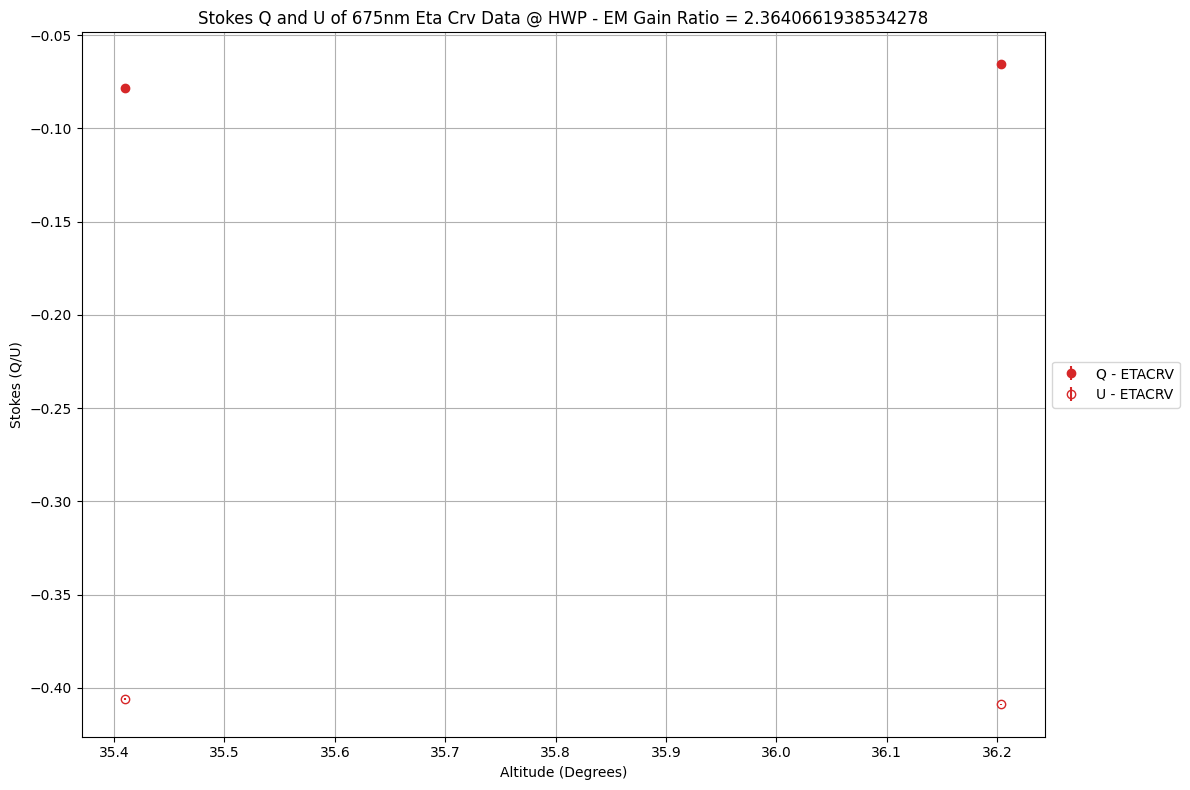

In [29]:
# Data File
csv_file = "/home/shared/exoserver/VAMPIRES/20220127/eta_crv/rz_dpp/collapsed/20240111_Eta_Crv_675_nm_Header_Parameters_R_15_Aperture_with_errors.csv"
df = pd.read_csv(csv_file)

# Extract unique objects and generate colors
unique_objects = all_data['OBJECT'].unique()
colors = itertools.cycle(plt.cm.tab10.colors)  # Use a colormap with a cycle of 10 colors

# Initialize lists for storing the results
wavelength = 675
Q_list = []
U_list = []
Q_err_list = []
U_err_list = []
final_altitudes = []

model = matrices.full_system_mueller_matrix

# Loop through each unique object
for obj in unique_objects:
    # Checking files VDATA20220128A_00001032.fits - VDATA20220128A_00001063.fits
    object_data = all_data[all_data['OBJECT'] == obj]
    color = next(colors)

    # Initialize lists for this object
    first_rows = []
    inst_matrices_at_HWP = []
    this_cycle_intensities = []
    this_cycle_altitudes = []
    this_cycle_errors = []

    for i, row in object_data.iterrows():

        # Extract the number between the first two underscores in the FILE_NAME and remove leading zeros
        file_number = int(row["FILE_NAME"].split('_')[1].lstrip('0'))
        
        # Check if the file number is between 1032 and 1063 (inclusive)
        if 1032 <= file_number <= 1063:
            # print(row["FILE_NAME"])
            HWP_ang = row["U_HWPANG"]
            IMR_ang = row["D_IMRANG"]
            cam_num = row["U_CAMERA"]
            FLC_state = row["U_FLCSTT"]
            parang = row["PA"]
            altitude = row["ALTITUDE"]
            data_Q = row["Q"]

            # NOTE: This is for normalized differences
            double_difference = row["DOUBLE_DIFFERENCE"]
            double_sum = row["DOUBLE_SUM"]
            double_difference_err = row["DOUBLE_DIFFERENCE_ERRS"]

            if double_difference != 0:
                # Append intensities and altitudes for this cycle
                this_cycle_intensities.append(double_difference)
                this_cycle_altitudes.append(altitude)
                this_cycle_errors.append(double_difference_err)

                # Calculate instrument matrix at HWP
                these_inst_matrices_at_HWP = matrices.full_system_mueller_matrix_normalized_double_diff_and_sum(
                    model, fixed_params, parang, altitude, HWP_ang, IMR_ang, factor = double_diff_factor)
                double_diff_matrix_at_HWP = these_inst_matrices_at_HWP[0]
                double_sum_matrix_at_HWP = these_inst_matrices_at_HWP[1]

                # Setting the I component to be 1
                # double_diff_matrix_at_HWP[0, 0] = 1

                # Saving instrument matrices
                inst_matrices_at_HWP.append(double_diff_matrix_at_HWP)
                inst_matrices_at_HWP.append(double_sum_matrix_at_HWP)

                # Take only the first row and I, Q, U, components (no V)
                first_rows.append(double_diff_matrix_at_HWP[0, : ] / double_sum_matrix_at_HWP[0, 0])   

            # Do one inversion for one HWP cycle
            if data_Q != 0:
                # Constructing measurement matrix to reconstruct Stokes vector at HWP
                measurement_matrix = np.vstack(first_rows)
                print(measurement_matrix)
                # measurements = np.array(this_cycle_intensities).reshape(-1, 1) - measurement_matrix[:, 0].reshape(-1, 1)  # Reshape total counts to a column vector
                errors = np.array(this_cycle_errors).reshape(-1, 1)  # Reshape errors to a column vector

                # measurement_matrix[:, 0] = 1
                # Compute the pseudo-inverse of the measurement matrix and multiply it by the measurements vector
                s_HWP = np.linalg.pinv(measurement_matrix[:,:-1]) @ measurements

                # Compute the errors for the Stokes parameters
                s_HWP_err = np.linalg.pinv(measurement_matrix[:,:-1]) @ errors

                # Extract Q and U from s_HWP and their errors
                Q = s_HWP[1]
                U = s_HWP[2]
                Q_err = s_HWP_err[1]
                U_err = s_HWP_err[2]

                # Append Q, U, altitude, and errors to the lists
                Q_list.append((altitude, Q, color, obj))
                U_list.append((altitude, U, color, obj))
                Q_err_list.append(Q_err)
                U_err_list.append(U_err)

                # Saving the mean of the altitudes
                mean_altitude = np.mean(this_cycle_altitudes)

                # Reset measurement matrix rows and double diff and sum measurements
                first_rows = []  
                this_cycle_intensities = []
                this_cycle_altitudes = []
                this_cycle_errors = []

                final_altitudes.append(mean_altitude)

# TODO: See if it's ok to just take the absolute uncertainties
Q_err_list = np.abs(Q_err_list)
U_err_list = np.abs(U_err_list)

# Plotting
plt.figure(figsize=(12, 8))
plotted_labels = set()
for (altitude, Q, color, obj), Q_err in zip(Q_list, Q_err_list):
    label = f'Q - {obj}' if f'Q - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, Q, yerr=Q_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor=color)
    plotted_labels.add(f'Q - {obj}')

for (altitude, U, color, obj), U_err in zip(U_list, U_err_list):
    label = f'U - {obj}' if f'U - {obj}' not in plotted_labels else None
    plt.errorbar(altitude, U, yerr=U_err, label=label, linestyle='None', marker='o', color=color, markerfacecolor='none', markeredgecolor=color)
    plotted_labels.add(f'U - {obj}')

plt.title(f"Stokes Q and U of {wavelength}nm Eta Crv Data @ HWP - EM Gain Ratio = " + str(em_gain))
plt.xlabel("Altitude (Degrees)")
plt.ylabel("Stokes (Q/U)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()
